In [89]:
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from sklearn import linear_model, preprocessing
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

In [90]:
def parseData(row):
    return datetime.strptime(row['Data'], "%Y-%m-%d")

def getCity(city, cities):
    dataframe = cities[cities['City'] == city]
    dataframe = dataframe[['16-06', '22-06', '29-06', '06-07', '13-07', '20-07', '10-08', '18-08', '24-08', '01-09', '07-09', '15-09', '21-09']]
    return dataframe.sum()

def groupCovid(df, start, end):
    df = df.sort_values(by="Data")
    df = df[(df['Data'] >= start) & (df['Data'] <= end)]
    
    groupedByWeek = df.groupby(df['Data'].dt.strftime('%W'))['casos']
    
    return groupedByWeek.sum()

def analyzeCity(cityAnalyzed, weeksAfter) -> pd.DataFrame:
    covid = pd.read_csv('../data/casos/covid-cases.csv')

    #remover colunas unamed
    covid.drop(covid.columns[covid.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    covid['Data'] = covid.apply (lambda row: parseData(row), axis=1)
    df = covid[covid['cidade'] == cityAnalyzed]
    cities = pd.read_csv('../data/distribuicao-tweets/distribuitionWithCity.csv')

    tweetsNormalizados = getCity(cityAnalyzed, cities)

    #normaliza dados
    tweetsNormalizados=(tweetsNormalizados-tweetsNormalizados.min())/(tweetsNormalizados.max()-tweetsNormalizados.min())
    covidDataByWeek = groupCovid(df, "2020-06-30", "2020-09-21")

    #normaliza dados
    covidDataByWeek=(covidDataByWeek-covidDataByWeek.min())/(covidDataByWeek.max()-covidDataByWeek.min())
    dfTweets = pd.DataFrame({'data':tweetsNormalizados.index, 'tweets na semana':tweetsNormalizados.values})
    dfTweets["id"] = dfTweets.index

    dfCasos = pd.DataFrame({'semana':covidDataByWeek.index, 'casos de covid na semana':covidDataByWeek.values})
    dfCasos["id"] = dfCasos.index + weeksAfter #compara com casos X semanas seguintes
    
    dadosAgrupados = pd.concat([dfTweets])
    dadosAgrupados = pd.merge(dadosAgrupados, dfCasos, on='id')
    dadosAgrupados = dadosAgrupados[['data', 'semana', 'tweets na semana', 'casos de covid na semana']]

    return dadosAgrupados 

In [91]:
def generate_data(weeks):
  cities = ["São Paulo", "Rio de Janeiro", "Belo Horizonte", "Fortaleza", "Porto Alegre", "Recife", "Manaus", "Salvador"]
  df = pd.DataFrame()
  for city in cities:
    current = analyzeCity(city, weeks)
    df = pd.concat([df, current])

  #x = semana + tweets na semana
  x_data = []
  tweets = np.array(df['tweets na semana'])

  i = 0
  for week in np.array(pd.to_numeric(df['semana'])):
    x_data.append([week, tweets[i]])
    i += 1

  #y = casos de covid na semana
  y_data = np.array(df['casos de covid na semana'])

  return x_data, y_data

def generate_linear_model(weeks):
  x_data, y_data = generate_data(weeks)

  reg = linear_model.LinearRegression().fit(x_data, y_data)
  print(f"Regressão linear. score: {reg.score(x_data, y_data)}")

  return reg, reg.score(x_data, y_data)

- São Paulo - casos de 4 semanas depois refletem os tweets dessa semana com 0.692619 corr
- Rio de Janeiro - casos de 4 semanas depois refletem os tweets dessa semana com -0.604875 corr
- Belo Horizonte - casos de 1 semana depois refletem os tweets dessa semana com 0.61064 corr
- Fortaleza - casos de 2 semanas depois refletem os tweets dessa semana com 0.631897 corr
- Porto Alegre - casos de 3 semanas depois refletem os tweets dessa semana com -0.617216 corr
- Recife - casos de 3 semanas depois refletem os tweets dessa semana com 0.579416 corr
- Manaus - casos de 4 semanas depois refletem os tweets dessa semana com -0.408583 corr
- Salvador - casos de 2 semanas depois refletem os tweets dessa semana com -0.326249 corr

In [92]:
zero, zero_score = generate_linear_model(0)
one, one_score = generate_linear_model(1)
two, two_score = generate_linear_model(2)
three, three_score = generate_linear_model(3)
four, four_score = generate_linear_model(4)

Regressão linear. score: 0.19997360191859204
Regressão linear. score: 0.06793312633630633
Regressão linear. score: 0.06058247166589348
Regressão linear. score: 0.024602117904640175
Regressão linear. score: 0.019686184501791937


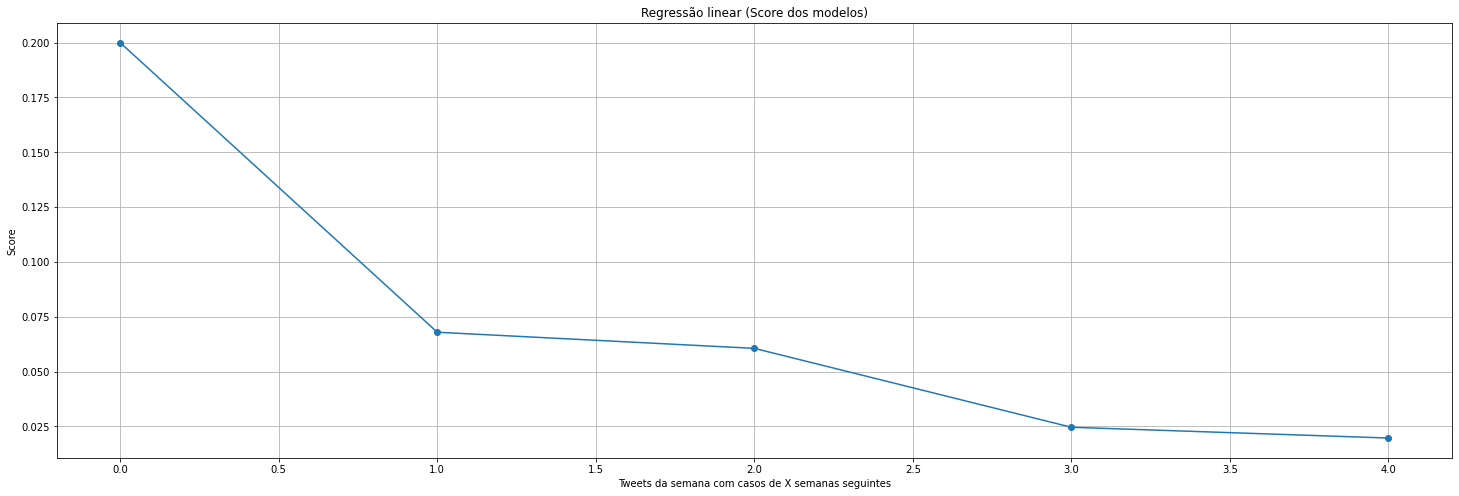

In [93]:
x = [0, 1, 2, 3, 4]
y = [zero_score, one_score, two_score, three_score, four_score]

fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(x, y, marker='o')

ax.set(xlabel='Tweets da semana com casos de X semanas seguintes', ylabel='Score', title='Regressão linear (Score dos modelos)')
ax.grid()

plt.show()

In [94]:
#teste pontual para tentativa de próximas semanas
one.predict(np.array([[35, 0.05]]))

array([0.5387062])

In [95]:
def generate_exp_model(weeks):
    def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
        return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(x_data, *parameterTuple)
        return np.sum((y_data - val) ** 2.0)


    def generate_Initial_Parameters():
        # min and max used for bounds
        maxX = max(x_data)
        minX = min(x_data)
        maxY = max(y_data)
        minY = min(y_data)

        parameterBounds = []
        parameterBounds.append([minX, maxX]) # search bounds for a
        parameterBounds.append([minX, maxX]) # search bounds for b
        parameterBounds.append([0.0, maxY]) # search bounds for Offset

        # "seed" the np random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, week):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
        axes = f.add_subplot(111)

        # first the raw data as a scatter plot
        axes.plot(x_data, y_data, 'D')

        # create data for the fitted equation plot
        xModel = np.linspace(min(x_data), max(x_data))
        yModel = func(xModel, *fittedParameters)

        # now the model as a line plot 
        axes.plot(xModel, yModel)

        axes.set_xlabel('Tweets na semana') # X axis data label
        axes.set_ylabel('Casos de covid na semana') # Y axis data label
        axes.set_title(f'Curva encontrada - {week}')
        plt.text(-0.05, 0.2, f'Parâmetros: {str(fittedParameters)}\nRMSE: {str(RMSE)}\nR^2: {str(Rsquared)}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()
        plt.close('all') # clean up after using pyplot

    cities = ["São Paulo", "Rio de Janeiro", "Belo Horizonte", "Fortaleza", "Porto Alegre", "Recife", "Manaus", "Salvador"]
    df = pd.DataFrame()
    for city in cities:
        current = analyzeCity(city, weeks)
        df = pd.concat([df, current])

    x_data = np.array(df['tweets na semana'])
    y_data = np.array(df['casos de covid na semana'])

    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, x_data, y_data, geneticParameters)

    print('Parameters', fittedParameters)

    modelPredictions = func(x_data, *fittedParameters) 

    absError = modelPredictions - y_data

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y_data))

    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    graphWidth = 800
    graphHeight = 600
    ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, weeks)
    return Rsquared


Parameters [ 9.00537909 -0.13971446 -0.38205345]
RMSE: 0.28000992249323425
R-squared: 0.07447810475258887


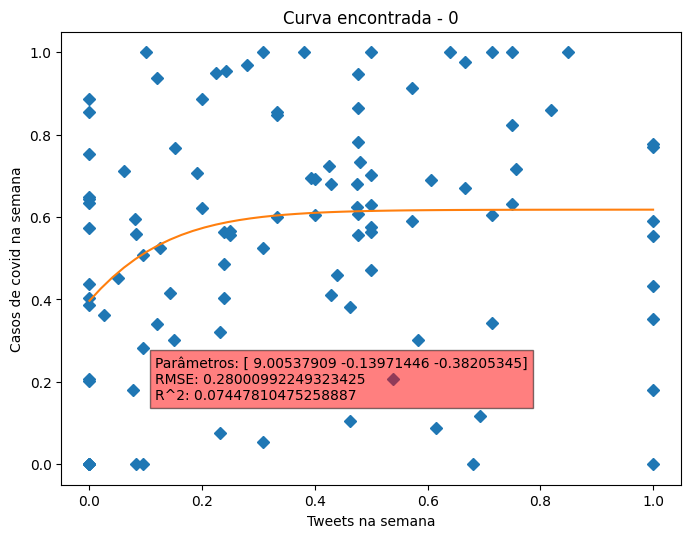

Parameters [13.25044671 -0.15548858 -0.36960043]
RMSE: 0.25291019331185394
R-squared: 0.026118984836305925


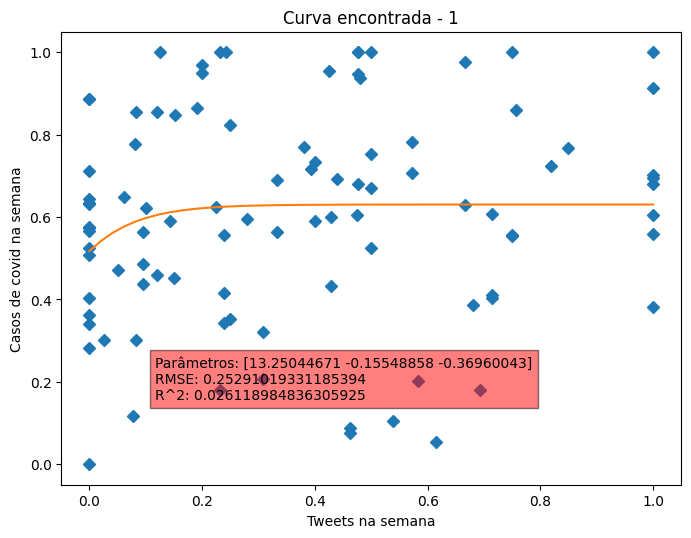

Parameters [ 3.99541378 -0.55392726 -0.3443052 ]
RMSE: 0.2581544482185581
R-squared: 0.017245401086775525


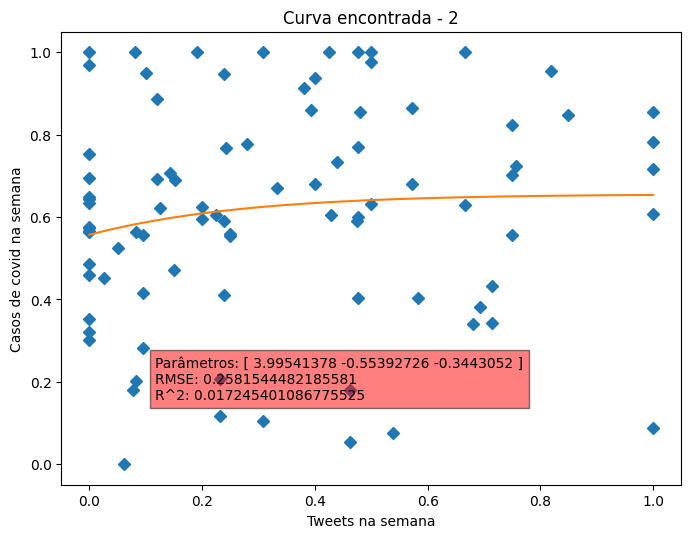

Parameters [ 5.22789206e+01 -4.68870830e-02 -3.50749024e-01]
RMSE: 0.2577670949433664
R-squared: 0.014784713814734562


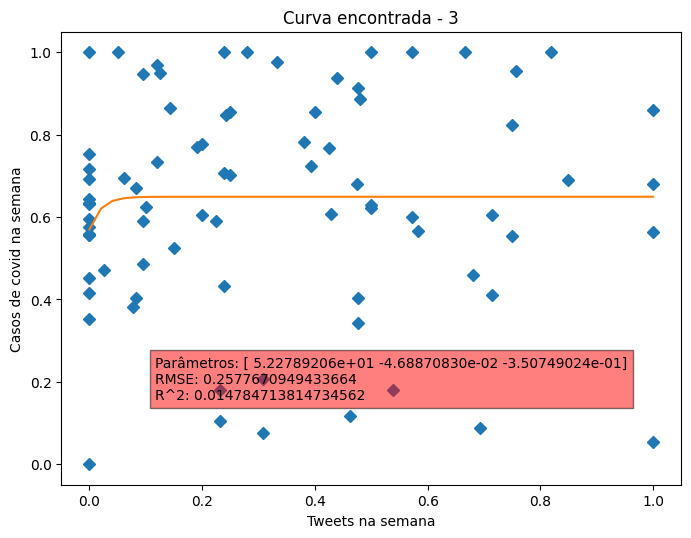

Parameters [-4.7712435  -0.50903344  0.61269789]
RMSE: 0.2525733685967288
R-squared: 0.013541856598714763


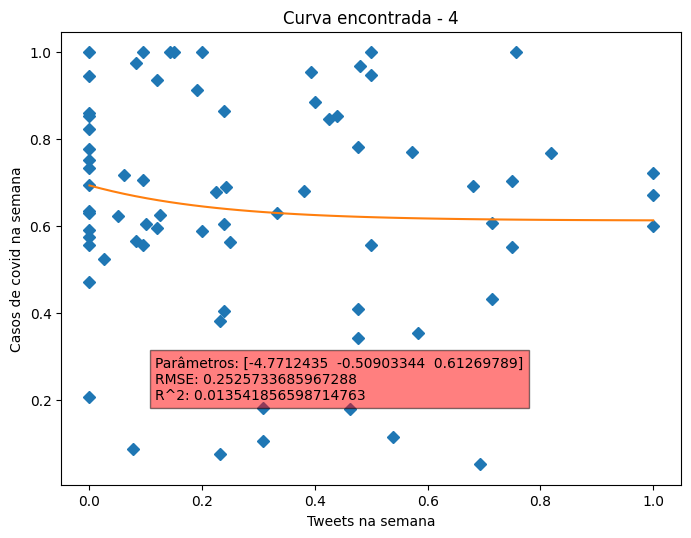

In [96]:
zero_exp = generate_exp_model(0)
one_exp = generate_exp_model(1)
two_exp = generate_exp_model(2)
three_exp = generate_exp_model(3)
four_exp = generate_exp_model(4)

y_exp = [zero_exp, one_exp, two_exp, three_exp, four_exp]

In [97]:
def generate_logistic_model(weeks):
  x_data, y_data = generate_data(weeks)

  lab_enc = preprocessing.LabelEncoder()
  y_data = lab_enc.fit_transform(y_data)

  reg = linear_model.LogisticRegression().fit(x_data, y_data)
  print(f"Regressão logística. score: {reg.score(x_data, y_data)}")

  return reg, reg.score(x_data, y_data)

zero, zero_logistic = generate_logistic_model(0)
one, one_logistic = generate_logistic_model(1)
two, two_logistic = generate_logistic_model(2)
three, three_logistic = generate_logistic_model(3)
four, four_logistic = generate_logistic_model(4)

Regressão logística. score: 0.1346153846153846
Regressão logística. score: 0.11458333333333333
Regressão logística. score: 0.125
Regressão logística. score: 0.1125
Regressão logística. score: 0.125


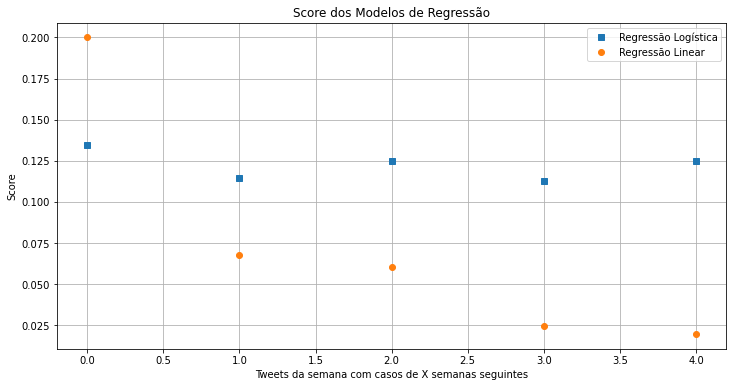

In [98]:
y_logistic = [zero_logistic, one_logistic, two_logistic, three_logistic, four_logistic]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x, y_logistic, linestyle='', marker='s', label="Regressão Logística")
ax.plot(x, y, linestyle='', marker='o', label="Regressão Linear")
ax.plot(x, y_exp, linestyle='', marker='D', label="Genético + Função Exponencial")

ax.set(xlabel='Tweets da semana com casos de X semanas seguintes', ylabel='Score', title='Score dos Modelos de Regressão')
ax.legend()
ax.grid()

plt.show()

In [99]:
#teste pontual para tentativa de próximas semanas
one.predict(np.array([[35, 0.05]]))

array([25])